<a href="https://colab.research.google.com/github/Tanelmina/Coursera-Advanced-Data-Science-Capstone/blob/master/IBM_DS_Capstone_17_VGG16%2BSVM%2BXGBOOST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Use Case

The purpose of current analysis is to investigate possibility of improving sound files classification in widespread using CNN accuracy with adding SVM or XGBoost to the algorithms pipeline. Hence the target is rather improvement in model classification precision, not precision value itself.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
path =  '/content/drive/My Drive/mudelid/AdCapstone/Toorandmed/bird17'
path_sample_sound = path +  'Toorandmed/songs/songs/xc' + str(dff.file_id[0]) +".flac"
path_sample_spectogramm = '/content/drive/My Drive/mudelid/AdCapstone/Toorandmed/bird17/Acrocephalus-arundinaceus/Acrocephalus-arundinaceus-129486.png'

### Importing libraries

In [ ]:
import keras
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import VGG16
from keras.applications.vgg16 import preprocess_input

from sklearn.svm import SVC
import xgboost as xgb

import numpy as np
import os
import cv2
import pandas as pd
import IPython

import librosa
from librosa import core, onset, feature, display

#%matplotlib inline
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt
from matplotlib.pyplot import imread

from sklearn.model_selection import train_test_split

### Preview of an audio clip

In [ ]:
IPython.display.Audio(path_sample_sound)

# Generating Mel Spectogramms

In [ ]:
n_mels = 370
sample_rate = 44100
sample_lenght = 4.0

In [ ]:
def load_mel_spectogramm(file_id):
    
    tee = path +  'Toorandmed/songs/songs/xc' + str(file_id) +".flac"
    y, sr = librosa.core.load(path = tee, sr=None, mono=True, offset=0.0, duration=sample_lenght,  res_type='kaiser_best')

    M = librosa.feature.melspectrogram(y=y, sr = sample_rate, n_mels=n_mels)         
    M = librosa.power_to_db(M, ref=np.max)
  
    return M

In [ ]:
df = pd.read_csv(path + 'Toorandmed/birdsong_metadata.csv')
df = df[['file_id','english_cname', 'genus']]
df['mel'] = 'default value'
df['name']= df.english_cname.astype("category").cat.codes

for i, row in dff.iterrows():
    id = row[0]
    mel = row[2]
    mel = load_mel_spectogramm(id)    
    dff.at[i,'mel'] = mel

Preview sample of Mel Spectogramm

(100, 545)

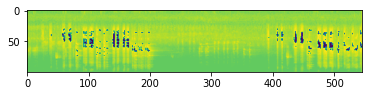

In [ ]:
sample = imread(path_sample_spectogramm)
plt.imshow(sample)
sample.shape

Delating spectogramms with different shape (too short)

In [ ]:
res = df['mel'][0].shape                          

for i, row in df.iterrows():
    mel = row[3]
    if mel.shape != res:
      print(mel.shape)
      df.drop(labels=i, axis=0, inplace=True, errors='raise')

## Applying datagenerator for CNN

In [ ]:
num_classes = len(next(os.walk(path))[1])     
image_resize = 224                           #  VGG16 pretrained model input
batch_size_training = 64
batch_size_validation = 64

In [ ]:
data_generator = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    validation_split = 0.2
)

In [ ]:
train_generator = data_generator.flow_from_directory(
    directory= path,
    target_size=(image_resize, image_resize),
    batch_size=batch_size_training,
    seed = 42,
    subset='training',
    class_mode='categorical')

Found 2378 images belonging to 17 classes.


In [ ]:
validation_generator = data_generator.flow_from_directory(
    directory= path,
    target_size=(image_resize, image_resize),
    batch_size=batch_size_validation,
    class_mode='categorical',
    seed = 42,
    subset='validation')

Found 588 images belonging to 17 classes.


# Applying VGG16

In [ ]:
model_vgg = Sequential()

In [ ]:
model_vgg.add(VGG16(
    include_top=False,
    pooling='avg',
    weights='imagenet',
    ))

58892288/58889256 [==============================] - 2s 0us/step


In [ ]:
model_vgg.add(Dense(1024, activation='relu')),
model_vgg.add(Dropout(0.5)),
model_vgg.add(Dense(num_classes, activation='softmax'))

In [ ]:
model_vgg.layers

In [ ]:
model_vgg.layers[0].layers

In [ ]:
model_vgg.layers[0].trainable = False

In [ ]:
model_vgg.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 512)               14714688  
_________________________________________________________________
dense (Dense)                (None, 1024)              525312    
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 17)                17425     
Total params: 15,257,425
Trainable params: 542,737
Non-trainable params: 14,714,688
_________________________________________________________________


In [ ]:
model_vgg.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
steps_per_epoch_training = len(train_generator)
steps_per_epoch_validation = len(validation_generator)
#steps_per_epoch_test = len(test_generator)

num_epochs = 40

In [ ]:
#from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
#reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.1, patience=20, verbose=1, min_lr=1e-8)
#early_stop = EarlyStopping(monitor='val_loss', verbose=1, patience=20,  restore_best_weights=True)
#checkpoint = ModelCheckpoint(filepath=path_model, monitor='val_loss', save_best_only=True,save_weights_only=True, mode='auto', save_freq='epoch', )

In [ ]:
path_model='/content/drive/My Drive/mudelid/AdCapstone/'

In [ ]:
model_vgg.load_weights(path_model)


In [ ]:
fit_history2 = model_vgg.fit_generator(
    train_generator,
    steps_per_epoch=steps_per_epoch_training,
    epochs=num_epochs,
    validation_data=validation_generator,
    validation_steps=steps_per_epoch_validation,
    verbose=1,
)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/40
38/38 [==============================] - 2044s 54s/step - loss: 3.8873 - accuracy: 0.2002 - val_loss: 2.1384 - val_accuracy: 0.3571
Epoch 2/40
38/38 [==============================] - 21s 565ms/step - loss: 2.1364 - accuracy: 0.3474 - val_loss: 2.0113 - val_accuracy: 0.3827
Epoch 3/40
38/38 [==============================] - 21s 564ms/step - loss: 1.8237 - accuracy: 0.4188 - val_loss: 1.9072 - val_accuracy: 0.4014
Epoch 4/40
38/38 [==============================] - 21s 563ms/step - loss: 1.6370 - accuracy: 0.4710 - val_loss: 1.8165 - val_accuracy: 0.4065
Epoch 5/40
38/38 [==============================] - 21s 563ms/step - loss: 1.5132 - accuracy: 0.5130 - val_loss: 1.8201 - val_accuracy: 0.4252
Epoch 6/40
38/38 [==============================] - 21s 563ms/step - loss: 1.4227 - accuracy: 0.5408 - val_loss: 1.8013 - val_accuracy: 0.4303
Epoch 7/40
38/38 [==============================] - 21s 562ms/step

VGG16 training results [validation set]¶


In [ ]:
results = model_vgg.evaluate(validation_generator,                          
                          batch_size=batch_size_validation)
print("test loss, test acc:", results)

10/10 [==============================] - 4s 385ms/step - loss: 2.3369 - accuracy: 0.4796
test loss, test acc: [2.336946725845337, 0.47959184646606445]


Plotting the chart for accuracy and loss on both training and validation


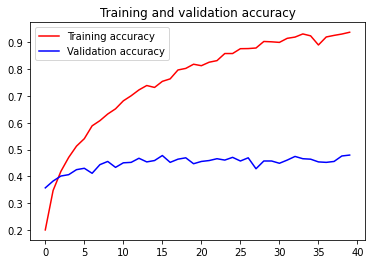

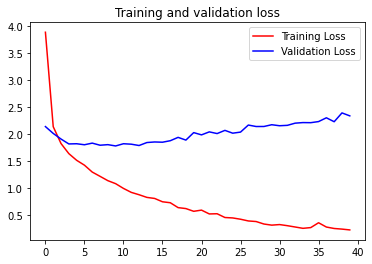

In [ ]:
acc = fit_history2.history['accuracy']     
val_acc = fit_history2.history['val_accuracy']   
loss = fit_history2.history['loss']   
val_loss = fit_history2.history['val_loss']  
epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')

plt.title('Training and validation loss')
plt.legend()

plt.show()

Saving model weights

In [ ]:
model_vgg.save_weights(path_model)

# Applying Suppot Vector Machine¶


Generating dataframe for train test splitting


In [ ]:
df = pd.DataFrame(index=None, columns=['Name','Image'])

for root, dirs, files in os.walk(path):  
    for name in files:
        if name.endswith((".png", ".jpg")):           
            im = cv2.imread(root + '/' + name)
            im = cv2.resize(im, (image_resize,image_resize), interpolation = cv2.INTER_AREA)
            nim =  name.rsplit(sep='-', maxsplit = 1)[0]
            df = df.append({'Name': nim, 'Image': im}, ignore_index=True)         

df['NameC']= df.Name.astype("category").cat.codes 

Train test splitting for SVM and XGBoost

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(
     df['Image'], df['NameC'], test_size=0.2, random_state=42)

print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)

(2372,)
(2372,)
(594,)
(594,)


In [ ]:
images = []
X = X_train

for pilt in X:
    images.append(pilt)

images = np.array(images).astype(float)  

images_train=images
images_train.shape

(2372, 224, 224, 3)

In [ ]:
images = []
X = X_val

for pilt in X_val:
    images.append(pilt)

images = np.array(images).astype(float)  

images_val=images
images_val.shape

(594, 224, 224, 3)

## Extracting Features from last Layer¶


In [ ]:
model_feat = Model(inputs=model_vgg.input,outputs=model_vgg.get_layer('dense').output)

feat_train = model_feat.predict(images_train)
print(feat_train.shape)

feat_val = model_feat.predict(images_val)
print(feat_val.shape)

#feat_test = model_feat.predict(x_test)
#print(feat_test.shape)

(2372, 1024)
(594, 1024)


# Applying SVM¶


In [ ]:
svm = SVC(kernel='rbf')
svm.fit(feat_train,y_train)
print('fitting done!')

fitting done !!!


Prediction Score [Training Features]¶


In [ ]:
svm.score(feat_train,y_train)

0.7879426644182125

Prediction Score [Validation Features]¶


In [ ]:
svm.score(feat_val,y_val)

0.5723905723905723

# Applying XGBOOST¶


In [ ]:
xb = xgb.XGBClassifier()
xb.fit(feat_train,y_train)
print('fitting done!')

fitting done !!!


Prediction Score [Training Features]¶


In [ ]:
xb.score(feat_train,y_train)

0.9721753794266442

Prediction Score [Validation Features]¶


In [ ]:
xb.score(feat_val,y_val)

0.5521885521885522

# Final Result

As to see, with using SVM or XGBoost on top layer of CNN we can significantly improve overall calssification accuracy.
